1. CÀI ĐẶT THƯ VIỆN

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")

2. ĐỌC VÀ TIỀN XỬ LÝ DỮ LIỆU

In [3]:
file_path = "Gold Futures Historical Data.csv"  
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].replace(',', '', regex=True).astype(float)
data = df[['Price']].values

df_cleaned = df[['Date', 'Price']] # Xuất dữ liệu
df_cleaned

,Date,Price
773,2022-01-03,1800.1
772,2022-01-04,1814.6
771,2022-01-05,1825.1
770,2022-01-06,1789.2
769,2022-01-07,1797.4
...,...,...
4,2024-12-27,2618.4
3,2024-12-30,2618.1
2,2024-12-31,2641.0
1,2025-01-02,2669.0


3. CHUẨN HÓA DỮ LIỆU

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

4. CHIA TẬP TRAIN VÀ TEST

In [5]:
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])
        y.append(data[i])
    return np.array(X), np.array(y)

time_step = 60 #Sử dụng 60 ngày làm đầu vào
train_size = int(len(scaled_data) * 0.9)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - time_step:]
last_sequence = scaled_data[-time_step:].reshape(-1, 1)

X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

5. TẠO VÀ HUẤN LUYỆN MÔ HÌNH

In [6]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

FIT MÔ HÌNH VỚI DỮ LIỆU TRAIN

In [7]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test), batch_size=64, verbose=1)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - loss: 0.0913 - val_loss: 0.0099
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0110 - val_loss: 0.0603
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0058 - val_loss: 0.0023
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0029 - val_loss: 0.0062
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0019 - val_loss: 0.0061
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/

6. DỰ ĐOÁN DỮ LIỆU TEST

In [8]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


(78, 1)

7. ĐÁNH GIÁ MÔ HÌNH

In [9]:
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 39.08
MAE: 29.79
MAPE: 1.12%


8. DỰ ĐOÁN GIÁ VÀNG TRONG 90 NGÀY

In [10]:
def predict_future_90days_with_print(model, last_sequence, scaler, start_date):
    all_preds = []
    current_seq = last_sequence.copy().reshape(-1, 1)

    for i in range(90):
        pred_scaled = model.predict(current_seq.reshape(1, current_seq.shape[0], 1), verbose=0)[0][0]
        pred = scaler.inverse_transform([[pred_scaled]])[0][0]

        # Lấy input 5 giá gần nhất
        input_sequence = scaler.inverse_transform(current_seq).flatten().tolist()
        input_last_5 = input_sequence

        # In ra kết quả
        print(f"Ngày {i+1} ({(start_date + pd.Timedelta(days=i+1)).date()}):")
        print(f"Input: {input_last_5}")
        print(f"Giá dự đoán: {pred:.2f}\n")

        # Lưu kết quả
        all_preds.append({
            "Ngày dự đoán": start_date + pd.Timedelta(days=i + 1),
            "Giá dự đoán": pred,
            "Input gần nhất ": input_last_5
        })

        # Cập nhật chuỗi
        current_seq = np.vstack([current_seq[1:], [[pred_scaled]]])

    return pd.DataFrame(all_preds)




In [11]:
start_date = df['Date'].iloc[-1]
df_future_90 = predict_future_90days_with_print(model, last_sequence, scaler, start_date)


Ngày 1 (2025-01-04):
Input: [2614.1, 2627.4, 2664.4, 2653.7, 2666.9999999999995, 2679.3, 2695.5, 2718.0, 2726.8, 2747.4, 2717.1, 2736.5, 2742.2, 2743.5999999999995, 2768.7999999999997, 2800.8, 2749.3, 2749.2, 2746.2, 2749.7, 2676.3, 2705.8, 2694.8, 2617.7, 2606.3, 2586.5, 2572.9, 2570.1, 2614.6, 2631.0, 2651.7, 2674.9000000000005, 2712.2, 2618.4999999999995, 2621.3, 2652.3, 2669.0, 2646.5, 2655.9, 2664.3, 2636.1, 2647.1, 2673.3, 2705.6, 2741.5, 2695.0999999999995, 2662.4, 2657.0, 2649.6, 2640.8000000000006, 2596.0, 2632.5, 2615.5, 2622.8000000000006, 2640.3, 2618.4, 2618.1, 2641.0, 2669.0, 2654.7]
Giá dự đoán: 2686.80

Ngày 2 (2025-01-05):
Input: [2627.4, 2664.4, 2653.7, 2666.9999999999995, 2679.3, 2695.5, 2718.0, 2726.8, 2747.4, 2717.1, 2736.5, 2742.2, 2743.5999999999995, 2768.7999999999997, 2800.8, 2749.3, 2749.2, 2746.2, 2749.7, 2676.3, 2705.8, 2694.8, 2617.7, 2606.3, 2586.5, 2572.9, 2570.1, 2614.6, 2631.0, 2651.7, 2674.9000000000005, 2712.2, 2618.4999999999995, 2621.3, 2652.3, 2669

9. VẼ BIỂU ĐỒ

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


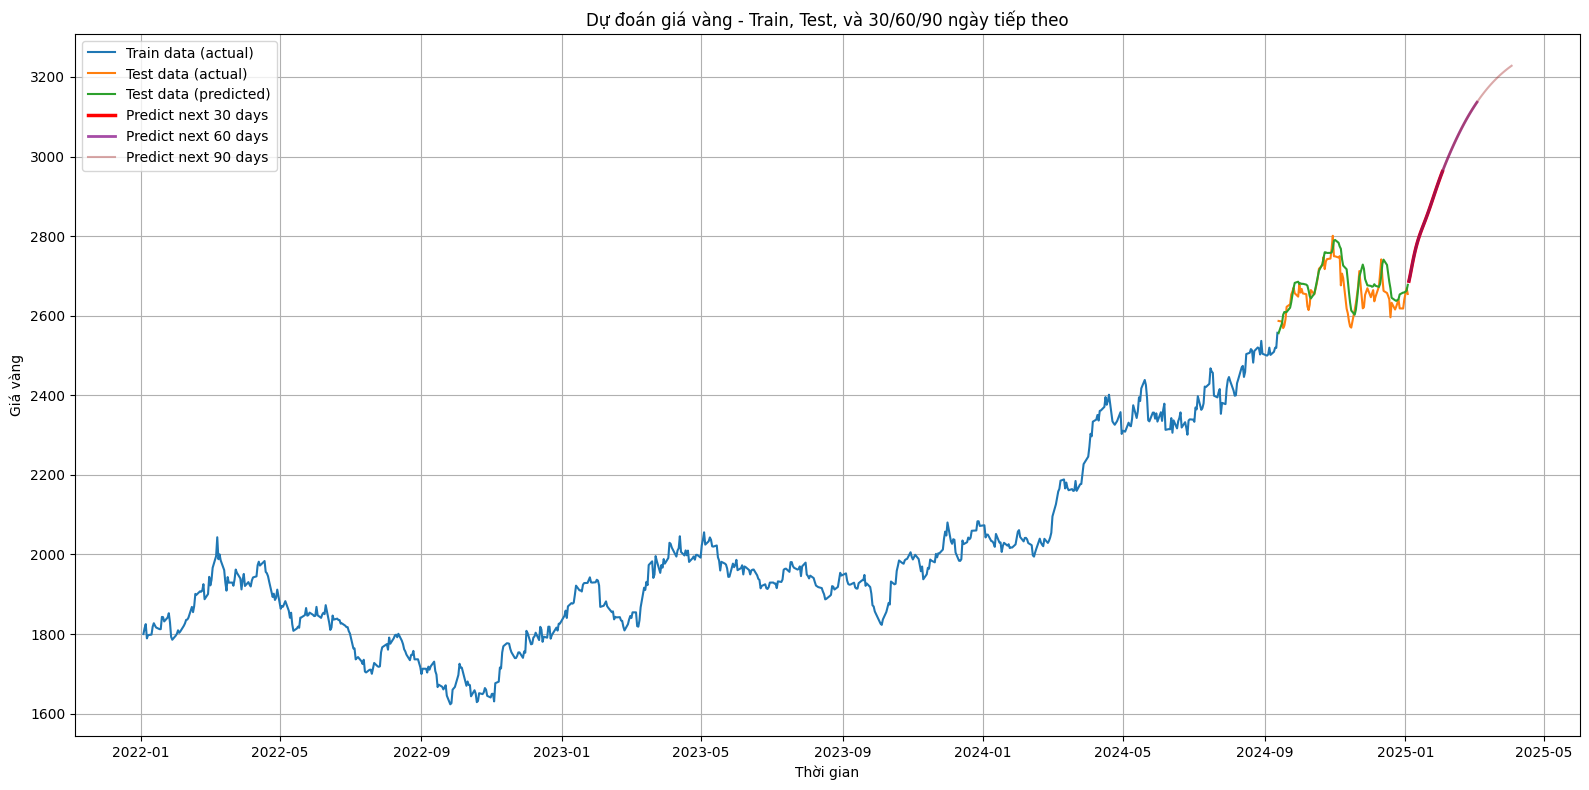

In [12]:
# Tạo các chuỗi ngày tương ứng
train_dates = df['Date'][:len(y_train) + time_step]
test_dates = df['Date'][len(y_train) + time_step:]

predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Các chuỗi dự đoán tương lai
future_30 = df_future_90.iloc[:30]
future_60 = df_future_90.iloc[:60]
future_90 = df_future_90

# Tạo ngày tương ứng cho tương lai
future_dates_30 = future_30['Ngày dự đoán']
future_dates_60 = future_60['Ngày dự đoán']
future_dates_90 = future_90['Ngày dự đoán']

plt.figure(figsize=(16, 8))

# 1. Train thực tế
plt.plot(train_dates, scaler.inverse_transform(scaled_data[:len(train_dates)]), label="Train data (actual)", linewidth=1.5)

# 2. Test thực tế
plt.plot(test_dates, actual_test, label="Test data (actual)", linewidth=1.5)

# 3. Test dự đoán
plt.plot(test_dates, predicted_test, label="Test data (predicted)", linewidth=1.5)

# 4. Dự đoán 30 ngày (đậm nhất)
plt.plot(future_dates_30, future_30['Giá dự đoán'], label="Predict next 30 days", linewidth=2.5, color='red')

# 5. Dự đoán 60 ngày (đậm vừa)
plt.plot(future_dates_60, future_60['Giá dự đoán'], label="Predict next 60 days", linewidth=2, color='purple', alpha=0.7)

# 6. Dự đoán 90 ngày (mờ nhất)
plt.plot(future_dates_90, future_90['Giá dự đoán'], label="Predict next 90 days", linewidth=1.5, color='brown', alpha=0.4)

plt.title("Dự đoán giá vàng - Train, Test, và 30/60/90 ngày tiếp theo")
plt.xlabel("Thời gian")
plt.ylabel("Giá vàng")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
